# Finding The Words - RSS and Simple Natural Language Processing in R
##### David Miller - July 2018 - [Link to Github](https://github.com/millerdw/millerdw.github.io/tree/master/_notebooks/FindingTheWords_1)
---

<img src="img\enigma-keyboard-banner.jpg" alt="Courtesy of http://mentalfloss.com/article/94486/what-was-flaw-enigma-machine" width="950px"/>

Changing tack a little since my last post in [Agricultural Approaches](), I wanted to skip ahead to something I'm particularly interested in. This is a big segue from my previous posts (not segway, that's something else entirely), hence the start of a new blog series. This way, I'm hoping to swap backwards and forwards between simple and higher level concepts, and between different subjects without bamboozling myself, or indeed anyone else, in the process.

I'm really interested in the ways in which algorithms can be used to analyse text. There is a profound amount of content, both generated historically and produced daily, that is based in language. Words are the closest humans have to representations of distinct ideas, and it's absolutely incredible how we use them.

At the risk of falling into a recursive loop; consider what I've written so far on the page, and how the black and white scratchings have (hopefully) conveyed meaning well above and beyond the pixels that make them up. Consider further how figurative language like "scratchings" and "above and beyond" don't just provide a literal meaning, but tap into associations that are common between a writer and their audience. Consider even further how when I refer to "a writer" and "their audience", even without any further information it's clear that I'm referring to myself and all of you because that's how people with an admittedly flowery disposition with words have spoken to you in the past... Consider even further again how... gaahhh abort,abort,abort...

Language is incredibly powerful and is a perfect insight into how humans not only perceive, but understand, the world around them. Beyond this, it has been shown that *Language affects a human's understanding of the world*; there is a feedback effect, whereby as language is learnt, our vocabulary *affects* how we differentiate between real world stimuli. This is known as the [Sapir-Whorf Hypothesis](http://www.linguisticsnetwork.com/wp-content/uploads/What-is-the-Sapir_Whorf-Hypothesis.compressed.pdf), and it might just be my favourite of all the 'ideas' or theories that I've ever come across (tied closely with the supposed etymology of the word "foreign" but, as this is probably apocryphal, I'll leave it for another time).

It's for these reasons I believe that understanding language is the key to understanding how we think. In this blog I want to explore the ways in which an algorithm can begin to get a handle on the former, and the steps required for us to begin to approximate the latter. 

I'll start with pretty simple ideas, because I'm learning here too, but hopefully we'll progress into areas that are genuinely taxing and interesting. Anyway, I've rambled on enough, I hope you enjoy it.

### Spit it Out

I always find that it's best to start with a good example, or project, in mind. In this case, I've been interested in the disparity between reportage of different news outlets for some time, even more so since the tail has begun to wag the dog in terrifying ways (see the EU Referendum and the 2016 US Election). I don't mean that as a political point, it's more that I remember the shock of finding out, twice in a year, that what I'd thought was a sure bet, what everything I'd read had said was a sure thing, turned out to be anything but. I decided that in an ideal world, whatever a persons views were, whatever their voting intention, everyone should be presented with the same facts, without bias or agenda. In reality this is near impossible, but the next best thing, surely, is to take all of those different biased and agenda driven publications, on both sides of the argument, and play them off against each other.

The trouble is, this data doesn't come nicely labelled for us. There are often tags telling us roughly what topic an article relates to (e.g. World, Sport, Lifestyle), but not describing the specific story. So, for the course of this series, my aim will be to **group different articles together based solely on their content**. 

I'm going to try and get stuck in as soon as possible and work things out as I go along, as is my habit, so hold on if the narrative takes a leap of faith or two, but hopefully you'll be able to see a structure emerge as we make some progress.


### Straight from the horse's mouth
#### Accessing RSS feeds

First things first, I'm going to walk through **collecting data from RSS feeds using an R library**. 

I'm using R in this case because it was the language that I originally began to prototype my model in when I started a few months back, and frankly it seems like a waste of time translating it into something else. I like to think I'm a clean coder though, so regardless of you're own personal preference of the tools to use, you should be able to follow along.

[RSS](https://en.wikipedia.org/wiki/RSS) (has lots of bacronymic translations, but I know it as Really Simple Syndication) feeds are just streams of text-based content organised in something akin to an XML format. It contains markers to denote the start and end of objects within the text stream, and has a limited set of properties for each object (Date, Title, Author, and so on). RSS appears to be falling out of favour lately, being replaced mainly by [json](https://www.json.org/) (JavaScript Object Notation), which allows for more flexibility in the objects being passed and parsed between the source server and the consumer application. More on that at another time, I guess.

Because of this common structure in RSS, it is *very* easy to parse the text stream into lists of objects in a programming environment, as a result there are lots of libraries available to help you do this, especially in an very open community like R's. Here I'm using a library called [feedeR](https://cran.r-project.org/web/packages/feedeR/index.html) to do the dirty work for me

**[Note]** A word of warning, always remember that the library your downloading is written by someone else who may or may not be a better, more diligent, or more motivated developer than you. This may not matter a jot (as in this case), but if you're considering building applications off of one then remember that you'll have absolutely noone to blame but yourself if a nasty bug emerges from said library at a later point in time. Remember also that each library will have a set of it's own weird dependencies, so you can download one or two and in reality be relying on five or ten different sets of code. (Being a .NET developer originally, I try to avoid building full blown apps in R anyway - there are better tools for that so use them - that said, very little beats this language in terms of prototyping and ad hoc analysis).

Below I've gone through the process of installing and loading all of the libraries relevant to our cause:


In [1]:
#install.packages(c('stringdist','feedeR','foreach','doParallel','rvest','magrittr','ggplot2'))

library(doParallel)
registerDoParallel(makeCluster(4))

library(foreach)
library(magrittr)
library(ggplot2)

library(feedeR)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


Yes, forgive me, I've set up the [doParallel](https://cran.r-project.org/web/packages/doParallel/index.html) library to add a little parallelism-juice to the process. This works really simply with the [foreach](https://cran.r-project.org/web/packages/foreach/index.html) library though (I can write `%dopar%` instead of `%do%` whenever I want to use it, so it shouldn't complicate proceddings too much. I've also included [magrittr](https://cran.r-project.org/web/packages/magrittr/index.html) to make R more like FSharp...

Now for the more interesting part. Below I've listed a series of active RSS sites I was able to find through google (hopefully of  different political persuasions), and I'm

In [2]:

## GATHER RAW DATA

# Define links for feeds
feeds <- c("http://feeds.bbci.co.uk/news/world/rss.xml",
            "http://feeds.bbci.co.uk/news/rss.xml",
            "http://feeds.skynews.com/feeds/rss/uk.xml",
            "http://feeds.skynews.com/feeds/rss/world.xml",
            "http://feeds.skynews.com/feeds/rss/us.xml",
            "http://feeds.reuters.com/Reuters/domesticNews",
            "http://feeds.reuters.com/Reuters/worldNews",
            "http://feeds.foxnews.com/foxnews/national",
            "http://feeds.foxnews.com/foxnews/world",
            "http://rssfeeds.usatoday.com/UsatodaycomWorld-TopStories",
            "http://rssfeeds.usatoday.com/UsatodaycomNation-TopStories",
            "http://rss.nytimes.com/services/xml/rss/nyt/World.xml",
            "http://www.nytimes.com/services/xml/rss/nyt/Africa.xml",
            "http://www.nytimes.com/services/xml/rss/nyt/Americas.xml",
            "http://www.nytimes.com/services/xml/rss/nyt/AsiaPacific.xml",
            "http://www.nytimes.com/services/xml/rss/nyt/Europe.xml",
            "http://www.nytimes.com/services/xml/rss/nyt/MiddleEast.xml",
            "http://www.nytimes.com/services/xml/rss/nyt/US.xml",
            "http://www.telegraph.co.uk/news/rss.xml"
            )


#download the dataset
dataset <- 
    #iterate through each feed address
    foreach(i=1:length(feeds), .combine=rbind) %do% {
        tryCatch({
            # extract items from each feed
            extract <- feed.extract(feeds[i])
            # return items with additional field of parent feed        
            cbind.data.frame(feed = extract$title, extract$items)
         }, error = function(e) { NULL }) #return NULL on an error (i.e. ignore it)
    }

#remove any duplicate entries, by checking each items url
dataset <- dataset[match(unique(dataset$link), dataset$link),]

#titles <- sapply(dataset$title, function(s) {(strsplit(gsub("[[:punct:]]", " ", tolower(s)), " ")) })

#show first 10
dataset[1:10,]

Space required after the Public Identifier
SystemLiteral " or ' expected
SYSTEM or PUBLIC, the URI is missing
Space required after the Public Identifier
SystemLiteral " or ' expected
SYSTEM or PUBLIC, the URI is missing
Space required after the Public Identifier
SystemLiteral " or ' expected
SYSTEM or PUBLIC, the URI is missing
Space required after the Public Identifier
SystemLiteral " or ' expected
SYSTEM or PUBLIC, the URI is missing
Space required after the Public Identifier
SystemLiteral " or ' expected
SYSTEM or PUBLIC, the URI is missing


feed,title,date,link,hash
BBC News - World,Lombok quake: Thousands evacuated after dozens die on Indonesia island,2018-08-06 11:13:27,https://www.bbc.co.uk/news/world-asia-45081508,002c4da4b0178eea
BBC News - World,Trump admits son met Russian for information on opponent,2018-08-06 11:28:56,https://www.bbc.co.uk/news/world-us-canada-45079377,51213109c533942b
BBC News - World,New Mexico: Police find 11 starving children in compound,2018-08-06 08:25:42,https://www.bbc.co.uk/news/world-us-canada-45079090,43be1c7bda3f6756
BBC News - World,Saudi Arabia freezes Canada trade ties for urging activists' release,2018-08-06 11:36:30,https://www.bbc.co.uk/news/world-middle-east-45079682,11c9b482b1ab8e32
BBC News - World,"Joel Robuchon, Michelin star French chef, dies aged 73",2018-08-06 11:11:26,https://www.bbc.co.uk/news/world-europe-45082668,25c1b3b1412841fd
BBC News - World,Australia backlash over far-right figure's TV interview,2018-08-06 03:14:04,https://www.bbc.co.uk/news/world-australia-45079617,7660c874bc5f77b3
BBC News - World,Bangladesh protests: How a traffic accident stopped a city of 18 million,2018-08-06 10:11:49,https://www.bbc.co.uk/news/world-asia-45080129,92642342eebff72d
BBC News - World,Tokyo 2020 Olympics: Japan debates daylight saving to avoid heat,2018-08-06 11:27:19,https://www.bbc.co.uk/news/world-asia-45080980,8cad7d30e0525309
BBC News - World,Diddy lived with the Amish and milked cows as a child,2018-08-06 10:14:29,https://www.bbc.co.uk/news/entertainment-arts-45082044,a9723c0fda36cd01
BBC News - World,InfoWars dropped from Facebook and iTunes,2018-08-06 10:47:16,https://www.bbc.co.uk/news/technology-45083684,6ea1f96e1a30b8f0


Excellent! There you have the top 10 stories from the feeds we investigated. You can take a look at the structure of these sites yourselves, just copy one of the links into your browser and go. Some of them are also manipulated to make them human-readable, but last I checked, the [NY Times World feed](http://rss.nytimes.com/services/xml/rss/nyt/World.xml) was sufficiently unformatted.

**A quick note -** The contents of these RSS feeds is obviously dynamic, and every time I refresh the notebook used to generate this post, the stories will change. In contrast, the text of the notebook is written in Markdown, and is therefore pretty static. I have a habit of writing "Great!", or "Excellent!" after completing some processing step, and depending on which stories this follows, that may be pretty jarring. ***Please don't take it as a comment on headlines written months after this post was created!***

#### Scraping content from article links
You may have noticed from the output above, but there's not *content* there... We've got a list of articles, with titles, dates and urls to their original source, but no actual data.

We now need to cycle through each of these links to download the contents of the HTML files at the other end. If we can parse this in a sensible way, we should be able to return raw text fields with the contents of each story into the application. There will probably be plenty of noise though, ads and paywalls etc, but that's something we'll have to deal with later.

This seems a bit daunting, but when I was looking at this previously I realised that there was a free pass in here. Luckily, language comes with an inherent structure, making the task of stripping content from the rest of the page's structure simper than it might sound. 

If you know your HTML, you'll know that developers generally put blocks of text into `<p></p>` blocks to make them manageable. As you'd probably expect, this is called a paragraph element and is designed specifically for this purpose. Further, each `<p>` block should, generally, contain a block of text that is self-consistent and self-contained, because this is how people write. It makes sense that these objects should exist, and websites should be designed in such a way to make a developer's life easier, but the by-product is that it makes sense to the consumer of that code as well.

Below I make use of yet another library, this one designed for scanning the html of websites. the [rVest](https://cran.r-project.org/web/packages/rvest/index.html) library is pretty popular for this purpose and is thankfully fairly easy to use.

With a few lines of code, it's possible to parse a webpage into a managed object, select the paragraph elements, convert them into text, and then use attributes from them to attempt to filter out noise from the signal.

In [7]:

# collate feed contents

contents <- 
    foreach(i = 1:nrow(dataset), combine = list, .packages = c('rvest','magrittr')) %dopar% {
        tryCatch({
            # read html using link from datasets, gather paragraph elements 
            paragraphs <- 
                read_html(dataset$link[i]) %>%
                html_nodes('p')
            
            # collect classes from paragaph elements, and convert contents to text
            p_classes <- html_attr(paragraphs, 'class')
            p_text <- html_text(paragraphs)
             
            # generate sequence of words from html content
            words <- 
                # filter text by the content of the classes
                p_text[is.na(p_classes) | grepl('intro', tolower(p_classes))] %>%
                # replace full stops with EOS tokens
                sapply(function(s) { gsub('\\. ',' ENDOFSEN ',s) }) %>%
                # split paragraph into separate words
                sapply(function(s) { strsplit(s, ' ')}) %>%
                unlist %>%
                as.character %>%
                # replace non-alphanumeric characters and remaining spaces with ''
                sapply(function(s) { tolower(gsub('[^[:alnum:][:space:]]', '', s)) })
            names(words) <- NULL
            words
        }, error = function(e) { '' })
    }
names(contents) <- 1:nrow(dataset)

t(contents[1])

1


Great! We've downloaded and stripped out the content of a large number of articles, removing non-alphanumeric characters and splitting the text by the spaces used, and converting everything into lower case (this is optional, because often case can be important, especially in character level analysis, but I've decided to ignore it; either lower or upper case is also fine, but I prefer less shouting).

Believe it or not, that's a pretty big step, and in most projects, the biggest issue is simple getting the data *into* your application. Still, we've just started so let's not pat ourselves on the back just yet.

## Getting to the point
### Representing the data
Now we have our news articles in a relatively clean and strucutured format, it's time to think about how we are going to go about grouping them together.

Before I start on the algorithm I'm going to use though, I need to represent our stories in a format that is palletable. Currently our `contents` object is a list articles, or more specifically, a list of lists of words. There's no constraint on one being longer than another, and there's no unified way of representing each one.

The trouble is, any grouping algorithm needs a measure of similarity to work; objects are part of the same group because they are more *similar* to each other than they are to the objects of a different group.

There are a number of different ways of measuring similarity, and most of them depend on creating vectors or vocabularies of words and measuring the distance between them in vector space (using [Euclidean Distance](https://en.wikipedia.org/wiki/Euclidean_distance) or [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) measures). Which of these to use, however, affects how you need to represent the data, and picking your representation system too soon can cause a bit of a "tail wags dog" scenario.

To keep things simple, I'm going to try and use a measure similar to a [Jaccard Distance](https://en.wikipedia.org/wiki/Jaccard_index) (you might know it as a form of Insterection over Union), which is effectively the ratio of the number of words shared by two texts to the number of words in both texts combined. In reality an IoU sin't exactly what we're interested in; if the texts are distinctly different lengths, but one is a precis of the other, the Jaccard distance wil be quite small, although we would call the texts very similar. Instead I will use the ratio of the number of shared words with the total length of the smaller text, which will always be a number less than or equal to 1 (1 would be a perfect match), but is more robust when comparing different sizes of text.

The benefit of using such a measure, is that I don't *need* to represent the data in any special or unified way; my list of lists of words is absolutely fine.

The weakness of this approach, however, is probably its simplicity. I can only compare the vocabularies used - the frequencies of words - I can't tell which words are more likely to go together, I can't make any clever assumptions about synonyms, can't even associate between singular and plural of the same nouns, or different cases of the same verbs. To do these things, generally, you need to develop an understanding of the language in the texts, an encoding of the rules of grammar or sentence structure - all of which favours vectorised manipulation of the data set. 

I want to cover [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis), and basic [Word Embeddings](https://en.wikipedia.org/wiki/Word_embedding) in another post, so I guess look out for that one! That said, there are a couple of tricks to try and help with this sort of comparison, which I'll try and develop further on in the post.


### Unsupervised Clustering
I'm going to start with a take on a [k-means](https://en.wikipedia.org/wiki/K-means_clustering) clustering algorithm. What this does is generate a prescribed number of cluster centroids (centre of the cluster) at random within your search 'space', works out which points of data are closest to which cluster, and then proceeds to find the arrangement that provides the minimum total distance between the points and their cluster. It's very simple, it can be affected by your random choice of clusters at the start, but is otherwise fairly robust.

In our case however, because we've avoided vectorising our data, we can't very easily pick a random point within that vector space. 

I'm trying a novel solution to this, which I don't **think** has appeared in literature. My idea is to put a constraint on the algorithm by enforcing that the centroid of each cluster must be an existing data point (or article). While the original k-Means algorithm has been proved to find the optimal...###

To summarise, my algorithm generates some starting centroids from randomly selected articles and then falls into a loop with 3 main steps:
1. Measure the distance (or unsimiliarity) of all articles to each centroid
2. Assign individuals to the closest centroid
3. Find a new centroid article that is the 'middle' of each cluster, i.e. has the smallest total distance from the rest of the individuals.

Eventually, the centroids will stop changing, and we will have a stable set of clusters. All that is required is to decide the number of centroids you want to start with, pick them at random and let it rip... in theory. 


#### Distance Metric
The first step is to define our distances, as I mentioned previously, I will be using a **Jaccard Distance** to measure the similarity of the texts. To make distance metrics interchangeable (good practice in prototyping an algorithm) I will write a function that takes two texts, A and B, that are lists of words, and returns a scalar value (float).

In [8]:
## Distance Metrics
### Jaccard Distance

jaccardDistance <- function(textA,textB) {
    ## find Jaccard Similarity
    similarityAtoB <- sum(c(textA) %in% c(textB))/sum(!is.na(c(textA)))
    similarityBtoA <- sum(c(textB) %in% c(textA))/sum(!is.na(c(textB)))

    ## generate measure of distance by mapping 0.0 to 1.0 similarity space onto an infinite to 0.0 unsimilarity space
    ##      when (similarity=0.0) then 
    ##          distance is very large (but not infinite)
    ##      when (similarity=1.0) then 
    ##          distance=0.0
    ##      when (similarity between 0.0 and 1.0)
    ##          distance scales like 1/x
    
    ((1. + 0.0001) / (similarityAtoB*similarityBtoA + 0.0001)) - 1
    #1-similarity
}

testIdA <- 11
testIdB <- 3

t(contents[[testIdA]])
t(contents[[testIdB]])
jaccardDistance(contents[[testIdA]],contents[[testIdB]])


the,last,member,of,an,immigrant,group,who,fought,the,...,yerevan,with,his,armenian,counterpart,at,the,time,serzh,sargsyan


police,in,the,us,state,of,new,mexico,have,rescued,...,rifle,and,four,pistols,when,they,encountered,him,they,said


[1] 4.515513

If you download this notebook from [my github page](https://github.com/millerdw/millerdw.github.io/tree/master/_notebooks/FindingTheWords_1), it will probably be valuable to 'play along'. I recommend changing the test IDs in the codeblock above and looking at how the distance measure changes with different pairs of texts.

#### Initial Parameters

Before running the algorithm, we have to define a number of variables. We've already covered the distance metric we're using in this case, but technically this is one of the parameters that you can change.

The next piece of information to define is $K$, or the number of clusters you want your algorithm to fill. It's an interesting topic in its own right, and a lot of research has been targeted at methods for dynamically finding the optimal number. The problem is, you have to define $K$ before you start, but the optimal value of it depends entirely on the shape of your data. In a simplified take on our example, $K_{opt}$ would be the total number of distinct news items in a day, regardless of who reported them. Obviously, if we knew this at the start, we probably wouldn't have a use for the algorithm!

I'm going to make an educated guess though, if each of our sources provide 30 stories each, then in the best case of there being a perfect 1:1 mapping, we'd only need 30 clusters. In reality I suspect that the overlap is somewhat less, so I've gone for 50, as shown below.

If I had more time, I'd be tempted to try something a little smarter, like having a maximum distance for a text to be included in a cluster, resulting in clusters, with unclustered 'satellite' texts around them. This might allow for 'better' or more compact clusters, but would obviously result in problems and idiosyncracies of it's own.


In [9]:

## K MEANS CLUSTERING

### define initial parameters
K <- 50      ## number of clusters
G <- 100     ## iteration or 'generation' limit
distance <- jaccardDistance

### define initial dataset (very simple)
corpus <- 
    names(contents)[sapply(contents, function(text) { length(text)>0})] %>% {
        filter <- contents[.]
        names(filter) <- .
        filter
    }


The biggest overhead of the algorithm, by a long way, is measuring the distance between the different texts, **for every single iteration**. Obviously the texts themselves don't change, and neither do the distances. In a classic, vectorised, k-means algorithm, the centroids of each cluster are somewhere in the same vector space as all of the data, which means additional distance measurements are required for each iteration. However, an added bonus of my enforcing that the centroid of a cluster must be an actual data point, is that **there are no other distance measurements required**.

This means that I can feasably calculate all of the distances between different texts beforehand, and save myself a shedload of time:

In [10]:
### SHORTCUT: store distances of each article to each article
storeDistances <- function(corpus,distance) {
    ## loop through all the combinations of text A vs text B
    foreach(idA=names(corpus), .combine=cbind, .packages=c('foreach')) %dopar% {
        foreach(idB=names(corpus), .combine=rbind) %do% {
            ## similarity of A vs B is the same as B vs A, so only do one side here...
            if(idA>idB) distance(corpus[[idA]],corpus[[idB]]) else 0.0
        } 
    } %>% {
        ## ...and fill in the gaps here
        . + t(.)
    } %>% {
        colnames(.) <- names(corpus)
        rownames(.) <- names(corpus)
        .
    }
}

distances <- storeDistances(corpus,distance)
distances[1:15,1:10]


,1,2,3,4,5,6,7,8,9,10
1,0.000000,3.263020,3.520461,3.656036,2.648285,5.573820,2.543507,3.705659,2.898571,4.393010
2,3.263020,0.000000,4.064242,4.967089,3.709977,4.909310,3.691114,5.237440,4.666064,4.835812
3,3.520461,4.064242,0.000000,4.825342,3.194891,4.948236,2.975233,5.929222,3.947595,4.176035
4,3.656036,4.967089,4.825342,0.000000,4.668842,6.135017,3.329659,4.899705,5.694739,5.567322
5,2.648285,3.709977,3.194891,4.668842,0.000000,4.907159,3.325452,3.839947,3.325452,4.370015
6,5.573820,4.909310,4.948236,6.135017,4.907159,0.000000,4.175185,6.860150,5.577405,5.688312
7,2.543507,3.691114,2.975233,3.329659,3.325452,4.175185,0.000000,3.996056,3.582542,3.529016
8,3.705659,5.237440,5.929222,4.899705,3.839947,6.860150,3.996056,0.000000,6.011537,6.247378
9,2.898571,4.666064,3.947595,5.694739,3.325452,5.577405,3.582542,6.011537,0.000000,4.981711
10,4.393010,4.835812,4.176035,5.567322,4.370015,5.688312,3.529016,6.247378,4.981711,0.000000


#### The Algorithm
Finally we get to describing the algorithm. I like to build these things as functions that take the defining variables as parameters (such as $K$, and the distance function or distances). This is a good idea for a number of reasons, I've highlighted a few below:

+ **Code Quality** 
    - scripted languages like R can cause havoc when variables are stored in memory rather than in code
+ **Reproduceability**
    - having the logic set in stone means that you can't catch erroneous results by 'fixing' something half way through a run
+ **Hyperparameter Tuning**
    - the code changes required to try different numbers of clusters, or different distance metrics, are minimal
    
In general I find that erring on the side of stricter coding serves me well in the long run, and significantly reduces the chance of unexplained bugs appearing in the longer term.

In this case, it's pretty simple, and I hope my coding is neat enough to follow without too much documentation. In order to understand the following though, it's important to know a couple of things:

1. The ID that links back to the dataset is generally encoded as the names of a list, or column or rownames of a table
    + e.g. `sample(names(corpus),K)` and `colnames(.) <- centroidIds`
2. Because I'm used to mapping objects, I make liberal use of the `foreach` function, which can return results in a specified type
    + e.g. `foreach(k=1:K, combine=list, ...)`, `foreach(k=c...Ids, .combine=cbind)` or `foreach(id=1:nrow(c...es), .combine=rbind)`

At the bottom of the block I call this function with the parameters that we've already set, and print out the history:


In [11]:
cluster<- function(corpus, K, G, distances) { 
    ### generate initial centroids
    centroidIds <- 
        # generate a list from a random sample of the corpus
        foreach(k=sample(names(corpus),K), combine=list) %do% k

    ### create history for storing generational performance
    history <- list()
    clusterAssignments <- NULL

    ### set generation to 1 and start looping
    g <- 1
    centroidsChanged <- T
    while (g <= G && centroidsChanged) {

        ### find distances of each article to each centroid
        centroidDistances <-
            foreach(k=centroidIds, .combine=cbind) %do% {
                distances[,k]
            } %>% {
                colnames(.) <- centroidIds
                .
            }

        ### assign each article its the closest centroid
        clusterAssignments <-
            foreach(id=names(corpus), combine=list) %do% {
                centroidDistances[id,] %>% { match(min(.),.) }
            } %>% {
                names(.) <- names(corpus)
                .
            }


        ### find new centroids
        newCentroidIds <-
            foreach(k=1:K, combine=list, .packages=c('foreach','magrittr')) %dopar% {
                if (sum(clusterAssignments==k)>0) {
                    clusterMemberIds <- names(clusterAssignments)[clusterAssignments==k]
                    clusterDistances <- distances[clusterMemberIds,clusterMemberIds] %>% as.data.frame

                    foreach(id=1:nrow(clusterDistances), .combine=rbind) %do% { 
                         sum(clusterDistances[id,]) 
                    } %>% { 
                        match(min(.),.)
                    } %>% {
                        clusterMemberIds[.]
                    }
                } else { 'empty' }
            }

        ### store performance 
        history <- 
            rbind(history,
                  cbind(generation=g,
                        foreach(k=1:K, .combine=cbind, .packages=c('foreach','magrittr')) %dopar% {
                            if (sum(clusterAssignments==k)>0) {
                                clusterMemberIds <- names(clusterAssignments)[clusterAssignments==k]
                                sum(distances[newCentroidIds[[k]],clusterMemberIds])/sum(!is.na(clusterMemberIds))
                            } else { NA }
                        } %>% {
                            colnames(.) <- sapply(1:K, function(k) { paste('Cluster',k,sep=' ') })
                            .
                        }))

        ### check loop conditions
        centroidsChanged <- F
        ## centroid
        for(k in 1:length(centroidIds)) { 
            centroidsChanged <- centroidsChanged || !(centroidIds[[k]] == newCentroidIds[[k]]) 
        }

        ### update centroids
        centroidIds <- c(newCentroidIds[!newCentroidIds=='empty'],
                         names(corpus)[!names(corpus) %in% centroidIds] %>% {
                            foreach(k=sample(.,K-length(centroidIds)), combine=list) %do% k 
                        })

        ### progress loop
        g <- g + 1
    }
    
    ### store performance 
    history <- 
        rbind(history,
              cbind(generation=g,
                    foreach(k=1:K, .combine=cbind, .packages=c('foreach','magrittr')) %dopar% {
                        if (sum(clusterAssignments==k)>0) {
                            clusterMemberIds <- names(clusterAssignments)[clusterAssignments==k]
                            sum(distances[newCentroidIds[[k]],clusterMemberIds])/sum(!is.na(clusterMemberIds))
                        } else { NA }
                    } %>% {
                        colnames(.) <- sapply(1:K, function(k) { paste('Cluster',k,sep=' ') })
                        .
                    }))
    
    ### return results
    list(history=history,
         clusterAssignments=clusterAssignments,
         centroidIds=centroidIds)
}



results <- cluster(corpus, K, G, distances)
results$history

generation,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,...,Cluster 41,Cluster 42,Cluster 43,Cluster 44,Cluster 45,Cluster 46,Cluster 47,Cluster 48,Cluster 49,Cluster 50
1,0,0,0,2.709285,1.166278,0.9179506,1.488236,1.899341,0,...,1.552979,2.632279,1.957824,0,3.641437,1.838585,0,0,0,NA
2,0,1.021797,0,2.60107,1.481003,0.9179506,2.025258,1.899341,0,...,2.632279,1.957824,0,3.661415,0.7701216,0,0,0,NA,NA
3,0,1.013842,0,2.60107,1.481003,0.9179506,2.025258,1.118716,0,...,2.632279,1.652976,0,3.661415,0.7701216,0,0,0,0,2.970959
4,0,1.013842,0,2.60107,1.481003,0.9179506,2.025258,1.118716,0,...,2.632279,1.652976,0,3.661415,0.7701216,0,0,0,0,2.970959


Outstanding! I'm really pleased with this... It's not perfect, but it clearly does the job.

If you're [playing along](https://github.com/millerdw/millerdw.github.io/tree/master/_notebooks/FindingTheWords_1), I highly recommend messing with the `checkCluster` variable in the block below, which selects a cluster to inspect. You'll see a number of things, some clusters that don't make much sense, and some that are clearly not catered for by the algorithm. I think most Reuters articles tend to get grouped because they have a common sign-off at the end...

In [13]:
### Change this variable to inspect a cluster
checkCluster <- 2

t(names(results$clusterAssignments)[results$clusterAssignments==checkCluster])
corpus[names(results$clusterAssignments)[results$clusterAssignments==checkCluster]] %>%
    sapply(t)


69,107,151,157,163


officials,in,indonesia,say,the,death,toll,from,a,powerful,...,a,quake,in,october,2010,which,also,left,15000,homeless
pemenang,indonesia,reuters,,rescuers,used,diggers,and,heavy,machinery,...,exchanges,and,delays,,2018,reuters,endofsen,all,rights,reserved
mataram,indonesia,,indonesian,authorities,said,monday,that,rescuers,still,...,press,writers,stephen,wright,and,ali,kotarumalos,in,jakarta,contributed
a,powerful,earthquake,of,70,magnitude,has,left,at,least,...,a,reporter,for,foxnewscom,endofsen,follow,him,on,twitter,travfed
jakarta,indonesia,,the,latest,on,an,earthquake,that,struck,...,are,not,allowed,to,exceed,the,height,of,coconut,trees


## Taking a step back

Before I plough on too far, I want to stop and take a look at where we are.

We've pulled article hyperlinks from an RSS feed into our script, used the links to scrape content of the articles themselves, and parsed them into clean-ish lists of words. From here, we've used something approximating a k-means clustering algorithm to group articles together based on their Jaccard similarity (or distance).

This on its own is a reasonable job done, but to top it off our results *look* pretty good... Because clustering is generally unsupervised (you don't have a set of labels to check against), it's really hard to tell how well you're doing. In the same way that it's difficult to pick $K$ before you start, it's hard to put a figure on how well you've done afterwards. 

As for the functioning of the algorithm itself though, I think we can be happy. Looking at the history table above, we can see that in general the mean distance of connections within each cluster falls, implying that the clustering gets better, generation by generation. I was expecting a larger number of generations than this, especially given the high dimensionality of the space (effectively $K$), but this is presumably lower due to the way in which we've hamstrung the algorithm to only return existing texts as centroids. The effects of this **discretisation** probably become less pronounced as we increase the size of the dataset, (and the make the space looks more continous), but that's an investigation for another time. 

I also note that some clusters 'die off', i.e become a cluster of one, which is essentially locked by the algorithm and can't be developed any further, but this can occur with any application of k-means. We could replace any such clusters with new, randomly selected articles, or as I've mentioned before, we could allow non-clusterable articles to exist 'unassigned', but with each adjustment like this we're adding more special cases, and making it more likely that our search could run a cropper.


### Measuring Cluster Quality
Coming back to this briefly, there are a couple of measures that we can use to estimate the quality of the clustering, but without a set of labels, i.e. "the answers", these will never be exact.

One simple one is the **ratio of mean inter-cluster distance to mean intra-cluster distances**. Generally, we want a larger number, i.e. where the centroids are further from each other than they are from their cluster members. I don't know what would be an acceptable benchmark value for this, but either way; large good, small bad: 

In [14]:
clusterQuality <- function(distances,results) {
    totalInterClusterDistance <-
        foreach(i=results$centroidIds, .combine=rbind) %do% {
            foreach(j=results$centroidIds, .combine=cbind) %do% {
                distances[i,j]
            } %>% mean(na.rm=T)
        } %>% mean(na.rm=T)
    
    meanIntraClusterTotalDistance <-
        foreach(k=results$centroidIds, .combine=cbind) %do% {
            members <- names(results$clusterAssignments)[results$clusterAssignments==k]
            if(length(members)>1) {
                foreach(i=members, .combine=rbind) %do% {
                    foreach(j=members, .combine=cbind) %do% {
                        distances[i,j]
                    } %>% mean(na.rm=T)
                } %>% mean(na.rm=T)
            } else { NA }
        } %>% mean(na.rm=T)
   
    totalInterClusterDistance/meanIntraClusterTotalDistance
}

clusterQuality(distances,results)

[1] 127.4459

This seems quite large, so I'm going to assume that this is a reasonable figure. We'll know for sure if I can compare it to a different set of clusters in the same corpus (more on that later).

### Visualising Clusters

It's also really helpful to have some idea of what's happening in the article 'space' as we're developing and algorithm like this.

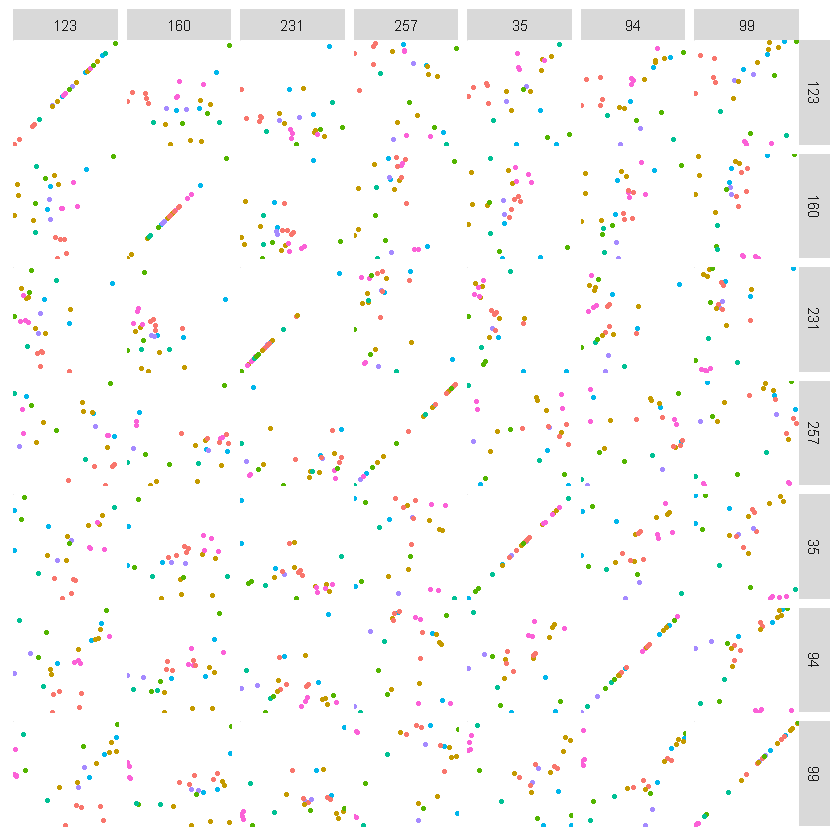

In [15]:
plotClusters <- function(distances,results,dims) {
        
    sampleCentroidIds <-
        results$history %>% { 
            #latest performance
            .[nrow(.),2:ncol(.)]
        } %>% {
            #excluding one-text clusters
            match(.[ . > 0], .)
        } %>% { 
            results$centroidIds[.]
        } %>% sample(dims) %>% unlist

    sampleCentroids <- (1:length(results$centroidIds))[results$centroidIds %in% sampleCentroidIds]

    measures <-
        #gather subset of IDs for texts in highlighted clusters
        foreach(i=names(results$clusterAssignments)[results$clusterAssignments %in% sampleCentroids], .combine=rbind) %do% {
            cbind(Id=i,
                  Cluster=results$centroidIds[[results$clusterAssignments[[i]]]],
                  t(distances[i,sampleCentroidIds]))
        }

    moltenMeasures <-
        foreach(i=sampleCentroidIds, .combine=rbind) %do% {
            foreach(j=sampleCentroidIds, .combine=rbind) %do% {
                #relevantMeasures <- measures[measures[,'Cluster'] %in% c(i,j),] %>% as.data.frame
                cbind(Cluster=measures[,c('Cluster')],
                      Measure1=i,
                      Value1=measures[,i],
                      Measure2=j,
                      Value2=measures[,j])
            }
        }  %>% 
        as.data.frame #%>% {
            #.[ .$Cluster==.$Measure1 | .$Cluster==.$Measure2,]
        #}

    ggplot(data = moltenMeasures,
           mapping = aes(x = Value1, y = Value2, colour = Cluster, group = Cluster)) +
        geom_point(show.legend = F, size=1.05) +
        facet_grid(Measure1 ~ Measure2) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              axis.title.y=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks.y=element_blank())

}

plotClusters(distances,results,7)

## Additional Measures

As I've discussed before, [w-shingling](https://en.wikipedia.org/wiki/W-shingling) is a very useful, and simple, method for adding a bit more depth to your word-counting algorithm. Essentially, it is another stage of input processing, during which a rolling window of `w` words is linked together to form the new 'words' of the text.

An algorithm that looks at the frequencies of single words is nothing more than a vocabulary analyser, but by extending this to include the frequencies of word combinations, or shingles, we can begin to discern between the meanings of two articles. The example I used previously is the difference between; "Donald Trump hates" and "hates Donald Trump" - a simple vocabulary analyser would not be able to tell the difference between the two, but something more complex, say shingling with 3 word groups, would have a better insight.

As you can see, shingling is a type of [n-gram](https://en.wikipedia.org/wiki/N-gram) model, and as a result we are able to set the size of each shingle, or gram, to best fit our purposes. This isn't the time for an in-depth discussion of hyperparameter tuning, but suffice is to say, some shingle sizes work better than others for each type of similarity problem. My intuition is that shorter shingles, say 3 or 5 words, might be better suited to content comparison models where the general gist of the text is under scrutiny, while longer shingles, say 10 or more, might be better suited to plagiarism detectors where finding exact language matches is the target.

In the example below I've used `w=3`, as I'm more interested in the relationships between words rather than in the exact replication of sentences. I've also appended the shingles to the original vocabulary, ensuring that we don't lose any of the information we gained from vocabulary just because it's not used in quite the same way.


In [16]:
## Shingling
w <- 3
shingles <-
    foreach(text=corpus, combine=list, .packages=c('foreach')) %dopar% {
        if (length(text)>(w-1)) {
            c(foreach(i=1:(length(text)-(w-1)), combine=list) %do% {
                    paste(c(text[i:(i+w-1)]), collapse="-")
              },text)
        } 
    } %>% {
        names(.) <- names(corpus)
        .
    }

shingles[[1]][1:10]

[[1]]
[1] "about-20000-people"

[[2]]
[1] "20000-people-have"

[[3]]
[1] "people-have-lost"

[[4]]
[1] "have-lost-their"

[[5]]
[1] "lost-their-homes"

[[6]]
[1] "their-homes-and"

[[7]]
[1] "homes-and-many"

[[8]]
[1] "and-many-moved"

[[9]]
[1] "many-moved-to"

[[10]]
[1] "moved-to-unaffected"

As you can see the process has converted the list of words into a list of daisy-chained shingles that behave like words in their own right. 

Although it's very simple, this helps encode some context of the language used into our algorithms analysis of each cluster. I hesitate to use the word *understanding* here though, as it implies that the algorithm has a context for these words greater that the corpus of text we've provided it with. It's also worth pointing out that **we've used our understanding of English to make these adjustments**, it hasn't been learnt by the algorithm (this is much more complicated, but hopefully I'll get onto that in a later post.

For now though, we can very simply use our well-though-out functions to cluster the dataset based on this new input:

In [17]:
shingleDistances <- storeDistances(shingles,distance)
shingleResults <- cluster(shingles, K, G, shingleDistances)
shingleResults$history

generation,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,...,Cluster 41,Cluster 42,Cluster 43,Cluster 44,Cluster 45,Cluster 46,Cluster 47,Cluster 48,Cluster 49,Cluster 50
1,0,0,13.91244,9.032652,11.59122,9.731989,2.234945,0,0,...,6.225248,5.764502,1.231688,0,11.68964,0,9.057129,0,5.956378,2.290604
2,0,0,14.29223,6.924146,11.59122,9.731989,2.365531,0.293057,0,...,0,11.68964,0,11.96223,0,0,2.290604,NA,NA,NA
3,0,0,14.29223,6.924146,11.59122,9.731989,2.234945,1.905434,0,...,0,11.68964,0,11.96223,0,0,2.290604,0,0,NA
4,0,0,14.29223,6.924146,11.59122,9.731989,2.234945,1.905434,0,...,0,11.68964,0,11.96223,0,0,2.290604,0,0,NA
5,0,0,14.29223,6.924146,11.59122,9.731989,2.234945,1.905434,0,...,0,11.68964,0,11.96223,0,0,2.290604,0,0,NA


In [21]:
### Change this variable to inspect a cluster
checkCluster <- 47

t(names(shingleResults$clusterAssignments)[shingleResults$clusterAssignments==checkCluster])
corpus[names(shingleResults$clusterAssignments)[shingleResults$clusterAssignments==checkCluster]] %>%
    sapply(t)


2,73


us,president,donald,trump,has,admitted,his,son,met,a,...,him,and,some,of,his,inner,circle,in,legal,jeopardy
donald,trump,has,admitted,that,his,son,met,with,a,...,ever,suggested,fires,could,be,halted,by,not,building,houses


### Measures of Improvement
The next step is to see if this has improved the quality of the clustering algorithm. We previously generated a cluster quality measure based on the relationship of inter- and intra-cluster distances, so let's apply that here to see if the measure improves.

In [22]:
clusterQuality(shingleDistances,shingleResults)

[1] 29.41018

... Unfortunately, it appears not. Just looking at examples though, it does *feel* like shingling has improved the quality of my algorithm, but this isn't being reflected in the measure. Given that the new algorithm still includes the old vocabulary, it seems more likely that the measure could be invalid, rather than that the clustering has become less effective.

There could be a number of reasons for this, not least that I haven't implemented the measure correctly, but it is also possible that the measure I'm using is looking for the 'wrong thing'. When I say 'quality of clustering' in reality I'm comparing the output of the algorithm to my own subjective beliefs, which are very difficult (or laborious) to include computationally. 

I still think that the clusters are closer together in the 'similarity-space' that we defined in this post, though. To back this up, take a look at the visualisations below:

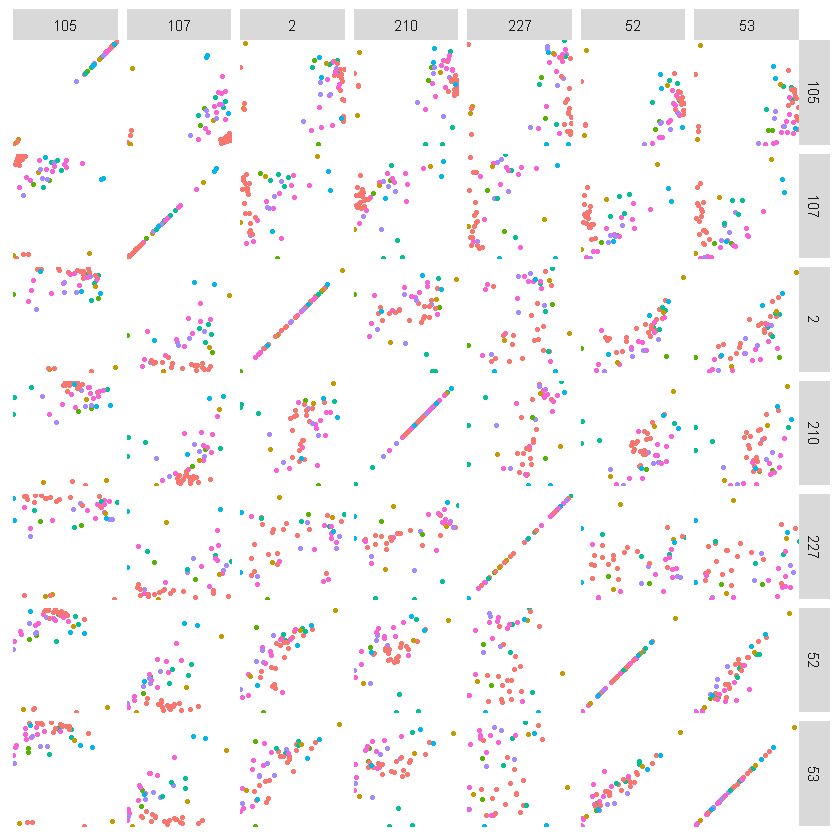

In [23]:
plotClusters(shingleDistances,shingleResults,7)

Anecdotally, these clusters seem to be a lot better defined than before, implying that there is a better measure of clustering quality available in the data to hand.

Sadly, this will have to wait for a later post, as I've already spent a fair whack of time on this one. Next time I'm going to be looking at vectorised implementations and word embeddings, so hopefully this will be slightly easier to implement as well.

## Summary
So there you have it; it *is* possible to use k-means on a non-vectorised corpus of text, and it *is* possible to use tricks like shingling to improve your results. We've also looked at visualising these results in many fewer dimensions, and I'm pretty happy with the results. I'm disappointed with the measure of cluster quality, but I'm leaving the section in because it's an interesting talking point and I want to revisit it later. This way you can follow my thought process a little better as well, which I think can be valuable to a reader.

This has been a fairly speedy whistle-stop tour of RSS management, web-scraping and text manipulation, and I haven't been able to go into much detail on any single point, but hopefully the thread of the article has still been coherent. Above all, I hope you've enjoyed reading this post, and I hope you've found it useful in some way. 

As always please download and play around with the notebook I used for this blog, the link to the Github page is below. If you have any comments, please raise an issue on the [Github project](https://github.com/millerdw/millerdw.github.io/tree/master/_notebooks/FindingTheWords_1) (I'm working on getting Discus included in the blog to make life a bit easier). Thanks for taking the time to read it!